# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="images/human_values.png" alt="human values" />
</center>

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

In [1]:
!pip install transformers==4.30.0
!pip install datasets==2.13.2
!pip install accelerate -U
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━

## Encode into DataFrame

In [2]:
# Mount the drive unit (ignore if you are working in local)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random
import keras
import numpy as np
import tensorflow as tf
import torch
import transformers
import os
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Reproducibility
seed = 23
#seed = 42
#seed = 87

random.seed(seed)
np.random.seed(seed)
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
transformers.set_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [4]:
import pandas as pd

dataset_folder = "/content/drive/MyDrive/Colab Notebooks/NLP/Assignments/Assignment_2/data/"  # CHANGE HERE THE DATA FOLDER

X_train_df = pd.read_table(dataset_folder + "arguments-training.tsv")
X_valid_df = pd.read_table(dataset_folder + "arguments-validation.tsv")
X_test_df = pd.read_table(dataset_folder + "arguments-test.tsv")

y_train_df = pd.read_table(dataset_folder + "labels-training.tsv")
y_valid_df = pd.read_table(dataset_folder + "labels-validation.tsv")
y_test_df = pd.read_table(dataset_folder + "labels-test.tsv")

In [5]:
X_train_df.head()

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [6]:
y_train_df.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A01006,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01007,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


## Merge level 2 annotations

In [7]:
# Define category 3 levels
opennes_to_change = ['Self-direction: thought',
                     'Self-direction: action',
                     'Stimulation',
                     'Hedonism']

self_enhancement = ['Hedonism',
                    'Achievement',
                    'Power: dominance',
                    'Power: resources',
                    'Face']

conservation = ['Face',
                'Security: personal',
                'Security: societal',
                'Tradition',
                'Conformity: rules',
                'Conformity: interpersonal',
                'Humility']

self_trascendence = ['Humility',
                     'Benevolence: caring',
                     'Benevolence: dependability',
                     'Universalism: concern',
                     'Universalism: nature',
                     'Universalism: tolerance',
                     'Universalism: objectivity']

categories_lvl3 = {
    'Opennes to change': opennes_to_change,
    'Self-enhancement': self_enhancement,
    'Conservation': conservation,
    'Self-trascendence': self_trascendence}

In [8]:
# Merge using logical OR over the columns corresponding to each category

# TRAIN SET
train_labels_df = pd.DataFrame({'Argument ID': y_train_df['Argument ID']})
for (name, category) in categories_lvl3.items():
  result_col = y_train_df[category[0]]
  for col in category[1:]:
      result_col = result_col | y_train_df[col]

  train_labels_df[name] = result_col

# VALIDATION SET
valid_labels_df = pd.DataFrame({'Argument ID': y_valid_df['Argument ID']})
for (name, category) in categories_lvl3.items():
  result_col = y_valid_df[category[0]]
  for col in category[1:]:
      result_col = result_col | y_valid_df[col]

  valid_labels_df[name] = result_col

# TEST SET
test_labels_df = pd.DataFrame({'Argument ID': y_test_df['Argument ID']})
for (name, category) in categories_lvl3.items():
  result_col = y_test_df[category[0]]
  for col in category[1:]:
      result_col = result_col | y_test_df[col]

  test_labels_df[name] = result_col

## Merge arguments and labels into the same dataframe

In [9]:
# Merge labels and arguments
train_df = X_train_df.merge(train_labels_df, how='inner', on='Argument ID')
valid_df = X_valid_df.merge(valid_labels_df, how='inner', on='Argument ID')
test_df = X_test_df.merge(test_labels_df, how='inner', on='Argument ID')

In [10]:
train_df.head()

,Argument ID,Conclusion,Stance,Premise,Opennes to change,Self-enhancement,Conservation,Self-trascendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


In [11]:
valid_df.head()

,Argument ID,Conclusion,Stance,Premise,Opennes to change,Self-enhancement,Conservation,Self-trascendence
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0,0,1,0
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,0,0,0,1
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,0,0,1,1
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,1,0,0,0
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,0,0,1,1


In [12]:
test_df.head()

,Argument ID,Conclusion,Stance,Premise,Opennes to change,Self-enhancement,Conservation,Self-trascendence
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,0,1,1,1
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,0,1,0,1
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,0,1,1,1
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,0,1,0,0
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,0,1,1,1


In [13]:
# drop Argument ID column
train_df = train_df.drop(['Argument ID'], axis =1)
valid_df = valid_df.drop(['Argument ID'], axis =1)
test_df = test_df.drop(['Argument ID'], axis =1)

In [14]:
from datasets import Dataset, DatasetDict

# Generate a dataset object for each dataframe
train_ds = Dataset.from_pandas(train_df, split='train')
valid_ds = Dataset.from_pandas(valid_df, split='valid')
test_ds = Dataset.from_pandas(test_df, split='test')

# Collect all datasets into a DatasetDict
dataset = DatasetDict({
    'train': train_ds,
    'valid': valid_ds,
    'test': test_ds
})

In [15]:
from transformers import AutoTokenizer

# Define model card
model_card = 'bert-base-uncased'

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_card)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
# List of labels and labels-id dict
LABELS = list(categories_lvl3.keys())
id2label = {idx:label for idx, label in enumerate(LABELS)}
label2id = {label:idx for idx, label in enumerate(LABELS)}

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(dataset['train']['Stance'])

array([1, 1, 0, ..., 1, 1, 1])

In [18]:
# Concatenate fields
def preprocess_text_C(records):
  return {'Data': str(records['Conclusion'])}

def preprocess_text_CP(records):
  return {'Data': str(records['Conclusion']) + '. ' + str(records['Premise'])}

def preprocess_text_CPS(records):
  return {'Data': str(records['Conclusion']) + '. ' + str(records['Premise']), 'encoded_stance': le.transform([records['Stance']])[0]}

C_processed_ds = dataset.map(preprocess_text_C)
CP_processed_ds = dataset.map(preprocess_text_CP)
CPS_processed_ds = dataset.map(preprocess_text_CPS)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

In [19]:
# Function for the encoding of the dataset
def tokenize_dataset(records):
  encoding = tokenizer(records['Data'], padding=True, return_tensors='pt')

  # add labels
  labels_batch = {cat: records[cat] for cat in LABELS}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(records['Data']), len(LABELS)))
  # fill numpy array
  for idx, label in enumerate(LABELS):
    labels_matrix[:, idx] = labels_batch[label]

  encoding['labels'] = labels_matrix.tolist()

  return encoding

In [20]:
C_encoded_ds = C_processed_ds.map(tokenize_dataset, batched=True, remove_columns=dataset['train'].column_names)
CP_encoded_ds = CP_processed_ds.map(tokenize_dataset, batched=True, remove_columns=dataset['train'].column_names)
CPS_encoded_ds = CPS_processed_ds.map(tokenize_dataset, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

In [21]:
train_ds = CPS_encoded_ds['train']
train_ds.set_format('pandas')
encoded_train_df = train_ds[:]
train_ds.reset_format()

encoded_train_df.head()

,Data,encoded_stance,input_ids,token_type_ids,attention_mask,labels
0,We should ban human cloning. we should ban hum...,1,"[101, 2057, 2323, 7221, 2529, 18856, 13369, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 1.0, 0.0]"
1,We should ban fast food. fast food should be b...,1,"[101, 2057, 2323, 7221, 3435, 2833, 1012, 3435...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 1.0, 0.0]"
2,We should end the use of economic sanctions. s...,0,"[101, 2057, 2323, 2203, 1996, 2224, 1997, 3171...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 1.0, 0.0]"
3,We should abolish capital punishment. capital ...,0,"[101, 2057, 2323, 11113, 20872, 2232, 3007, 77...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 1.0, 1.0]"
4,We should ban factory farming. factory farming...,0,"[101, 2057, 2323, 7221, 4713, 7876, 1012, 4713...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 1.0, 1.0]"


In [22]:
# Pick up a random sample from the train dataset
id = random.randint(0, len(CPS_encoded_ds['train']))
sample = CPS_encoded_ds['train'][id]

# Decode random sample
print(tokenizer.decode(sample['input_ids']))

print()

# Decode its labels
print([id2label[idx] for idx, label in enumerate(sample['labels']) if label == 1.0])

[CLS] we should abolish capital punishment. being killed by lethal injection or being electrocuted is not always smooth and painless, sometimes it causes a painful death [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

['Conservation']


# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

## Baseline models

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

class MyDummyClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self,strategy = 'uniform', random_state=None, labels=LABELS):
    self.strategy = strategy
    self.random_state = random_state
    self.dummy_clfs = None
    self.labels = labels
    self.predictions = None

  def fit(self,X,y):
    self.dummy_clfs = [DummyClassifier(strategy=self.strategy,random_state=self.random_state) for _ in range(y.shape[1])]
    for i,clf in enumerate(self.dummy_clfs):
      clf.fit(X,y.iloc[:,i])
    return self

  def predict(self,X):
    predictions = np.array([clf.predict(X) for clf in self.dummy_clfs])
    return predictions.transpose()

  def score(self,y_true,y_pred):
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    f1_perclass = f1_score(y_true=y_true, y_pred=y_pred, average=None)
    return {
        'macro-F1': f1_macro,
        'Opennes to Change F1': f1_perclass[0],
        'Self-enhancement F1': f1_perclass[1],
        'Conservation F1': f1_perclass[2],
        'Self-trascendence F1': f1_perclass[3]
        }


In [24]:
def rand_uniform_cls(n_samples, n_labels):
  threshold = 0.5 # Equally probable to get 0 or 1

  predictions = tf.random.uniform(shape=(n_samples, n_labels), minval=0, maxval=1)
  predictions = tf.cast((predictions > threshold), dtype='int32').numpy()

  return predictions

In [25]:
def majority_cls(n_samples):
  # Find the majority label for each category
  category_votes = np.array([[np.argmax(np.bincount(dataset['train'][name])) for name in list(categories_lvl3.keys())]])

  # Repeat the resulting row for every sample
  predictions = np.repeat(category_votes, n_samples, axis=0)

  return predictions

## Model Definition

In [26]:
class Classifier(torch.nn.Module):
  """
  Basic classifier that will be used for each category
  """
  def __init__(self, stance):
    super(Classifier, self).__init__()

    # We need to add a unit in case of adding the stance
    emb_size = 769 if stance else 768

    self.linear1 = torch.nn.Linear(emb_size, 1536)
    self.activation = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(1536, 2)
    self.softmax = torch.nn.Sigmoid()

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation(x)
    x = self.linear2(x)
    x = self.softmax(x)
    return x

In [27]:
class BERTClass(torch.nn.Module):
  """
  Model that will be used to classify each sentence. The structured is the following:

  Bert-Transformer -> Classifier (one per class)
  """
  def __init__(self, stance):
    super(BERTClass, self).__init__() # Init superclass

    self.stance = stance  # If the model includes the stance or not

    self.embedding = transformers.BertModel.from_pretrained('bert-base-uncased')
    self.dropout = torch.nn.Dropout(0.3)  # Regularization

    # Classifiers
    self.OTC_cls = Classifier(self.stance)
    self.SEnh_cls = Classifier(self.stance)
    self.Cons_cls = Classifier(self.stance)
    self.STra_cls = Classifier(self.stance)

  def forward(self, input_ids, token_type_ids, attention_mask, labels, encoded_stance = None):

    _, pooled_output = self.embedding(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, return_dict=False)

    # If the model includes stance, concatenate it
    if self.stance:
      encoded_stance_unsq = encoded_stance.unsqueeze(-1)
      pooled_output = torch.cat([pooled_output, encoded_stance_unsq], dim=1).to(dtype=torch.float)

    pooled_output = self.dropout(pooled_output)

    OTC_output = self.OTC_cls(pooled_output)
    SEnh_output = self.SEnh_cls(pooled_output)
    Cons_output = self.Cons_cls(pooled_output)
    STra_output = self.STra_cls(pooled_output)

    logits = torch.stack([OTC_output, SEnh_output, Cons_output, STra_output], dim=-1).to(dtype=torch.float)

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(logits, labels.to(dtype=torch.long))

    return {'loss': loss, 'logits': logits}

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

In [28]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(evaluations,are_probs = True):
    pred, label = evaluations

    targets = np.argmax(pred, axis=1) if are_probs else pred

    f1_macro = f1_score(y_true=label, y_pred=targets, average='macro')
    f1_perclass = f1_score(y_true=label, y_pred=targets, average=None)

    return {
        'macro-F1': f1_macro,
        'Opennes to Change F1': f1_perclass[0],
        'Self-enhancement F1': f1_perclass[1],
        'Conservation F1': f1_perclass[2],
        'Self-trascendence F1': f1_perclass[3]
        }

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

#### Define training parameters

### BASELINE MODELS

In [29]:
rand_unif_class = MyDummyClassifier(strategy='uniform')

In [30]:
rand_unif_class.fit(train_df['Conclusion'], train_df[LABELS])
ruc_preds = rand_unif_class.predict(test_df['Conclusion'])
ruc_metrics = rand_unif_class.score(test_df[LABELS],ruc_preds)

In [31]:
majority_class = MyDummyClassifier(strategy='most_frequent')

In [32]:
majority_class.fit(train_df['Conclusion'], train_df[LABELS])
mc_preds = majority_class.predict(test_df['Conclusion'])
mc_metrics = majority_class.score(test_df[LABELS],mc_preds)

In [33]:
batch_size = 8
#metric_name = "macro-F1"

In [34]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-base-uncased-assignment2",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

### BERT w/C

In [35]:
model_C = BERTClass(stance=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
model_C

BERTClass(
  (embedding): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [37]:
trainer_C = Trainer(
    model_C,
    args,
    train_dataset=C_encoded_ds["train"],
    eval_dataset=C_encoded_ds["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [38]:
trainer_C.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Macro-f1,Opennes to change f1,Self-enhancement f1,Conservation f1,Self-trascendence f1
1,0.615900,0.596585,0.560324,0.000000,0.497417,0.858519,0.885362
2,0.594400,0.593266,0.671471,0.352127,0.589878,0.858519,0.885362
3,0.581600,0.595073,0.676825,0.353982,0.624052,0.843905,0.885362
4,0.573800,0.595391,0.676592,0.355340,0.621762,0.843905,0.885362
5,0.572000,0.593994,0.675538,0.360976,0.611907,0.843905,0.885362


TrainOutput(global_step=3375, training_loss=0.5840230034722222, metrics={'train_runtime': 409.8106, 'train_samples_per_second': 65.799, 'train_steps_per_second': 8.236, 'total_flos': 0.0, 'train_loss': 0.5840230034722222, 'epoch': 5.0})

### BERT w/CP

In [39]:
model_CP = BERTClass(stance=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
trainer_CP = Trainer(
    model_CP,
    args,
    train_dataset=CP_encoded_ds["train"],
    eval_dataset=CP_encoded_ds["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [41]:
trainer_CP.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Macro-f1,Opennes to change f1,Self-enhancement f1,Conservation f1,Self-trascendence f1
1,0.594600,0.563750,0.701371,0.468208,0.589445,0.863455,0.884374
2,0.538000,0.556275,0.726068,0.494940,0.656546,0.868159,0.884627
3,0.500700,0.556302,0.743549,0.553366,0.672141,0.862189,0.886499
4,0.478500,0.555156,0.742727,0.552301,0.664671,0.865774,0.888162
5,0.468500,0.554053,0.748674,0.577453,0.665472,0.864950,0.886821


TrainOutput(global_step=3375, training_loss=0.5100576623987269, metrics={'train_runtime': 968.9209, 'train_samples_per_second': 27.83, 'train_steps_per_second': 3.483, 'total_flos': 0.0, 'train_loss': 0.5100576623987269, 'epoch': 5.0})

### BERT w/CPS

In [42]:
model_CPS = BERTClass(stance=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
trainer_CPS = Trainer(
    model_CPS,
    args,
    train_dataset=CPS_encoded_ds["train"],
    eval_dataset=CPS_encoded_ds["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [44]:
trainer_CPS.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Macro-f1,Opennes to change f1,Self-enhancement f1,Conservation f1,Self-trascendence f1
1,0.606900,0.563725,0.731493,0.588751,0.603413,0.852313,0.881497
2,0.542100,0.553810,0.746827,0.557143,0.682270,0.862079,0.885815
3,0.500100,0.554187,0.737620,0.557971,0.643166,0.863931,0.885411
4,0.478400,0.554297,0.756882,0.606245,0.672434,0.864564,0.884285
5,0.467100,0.554466,0.760388,0.610860,0.678389,0.866206,0.886099


TrainOutput(global_step=3375, training_loss=0.512423755787037, metrics={'train_runtime': 975.7635, 'train_samples_per_second': 27.635, 'train_steps_per_second': 3.459, 'total_flos': 0.0, 'train_loss': 0.512423755787037, 'epoch': 5.0})

In [50]:
# get predictions
predictions_C = trainer_C.predict(test_dataset=C_encoded_ds['valid'])
predictions_CP = trainer_CP.predict(test_dataset=CP_encoded_ds['valid'])
predictions_CPS = trainer_CPS.predict(test_dataset=CPS_encoded_ds['valid'])

In [51]:
metric_fields = ['test_macro-F1','test_Opennes to Change F1','test_Self-enhancement F1','test_Conservation F1','test_Self-trascendence F1']
metrics_C =[predictions_C.metrics[key] for key in metric_fields ]
metrics_CP =[predictions_CP.metrics[key] for key in metric_fields ]
metrics_CPS =[predictions_CPS.metrics[key] for key in metric_fields ]

In [52]:
f1_metric = pd.DataFrame(data=[ruc_metrics.values(),mc_metrics.values(),metrics_C,metrics_CP,metrics_CPS],
                       columns = ['macro-F1','Opennes to Change F1','Self-enhancement F1','Conservation F1','Self-trascendence F1'],
                       index=['Rand Unif Class','Majority Class','BERT w/C','BERT w/CP','BERT w/CPS'])

In [53]:
f1_metric

,macro-F1,Opennes to Change F1,Self-enhancement F1,Conservation F1,Self-trascendence F1
Rand Unif Class,0.498857,0.369255,0.444292,0.548180,0.633701
Majority Class,0.430532,0.000000,0.000000,0.830427,0.891702
BERT w/C,0.671471,0.352127,0.589878,0.858519,0.885362
BERT w/CP,0.748674,0.577453,0.665472,0.864950,0.886821
BERT w/CPS,0.746827,0.557143,0.682270,0.862079,0.885815


# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

In [49]:
# Generate random index for samples
samples = [random.randint(0, len(test_df)) for i in range(10)]
print(f"Generated random indices: {samples}")
print()

# convert predictions probs in labels
preds_C = np.argmax(predictions_C.predictions, axis=1)
preds_CP = np.argmax(predictions_CP.predictions, axis=1)
preds_CPS = np.argmax(predictions_CPS.predictions, axis=1)

# See some examples
results = pd.DataFrame(data=[[CPS_encoded_ds['test']['Data'][s],CPS_encoded_ds['test']['encoded_stance'][s],CPS_encoded_ds['test']['labels'][s],ruc_preds[s],mc_preds[s],preds_C[s],preds_CP[s],preds_CPS[s]] for s in samples],
                       columns=['Data','Stance','True labels','Rand Unif Class','Majority Class','Bert C','Bert CP','Bert CPS']
                       )
results.head(10)

Generated random indices: [1309, 228, 51, 1518, 563, 501, 457, 285, 1508, 209]



,Data,Stance,True labels,Rand Unif Class,Majority Class,Bert C,Bert CP,Bert CPS
0,We should deal with gender inequality. Though ...,1,"[0.0, 0.0, 1.0, 1.0]","[0, 1, 0, 0]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]"
1,We should prohibit flag burning. despite polit...,1,"[0.0, 0.0, 1.0, 0.0]","[1, 1, 1, 0]","[0, 0, 1, 1]","[1, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]"
2,We should ban naturopathy. we should not ban n...,0,"[1.0, 1.0, 1.0, 1.0]","[0, 0, 0, 0]","[0, 0, 1, 1]","[1, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]"
3,We should deprivatize the healthcare industry....,0,"[1.0, 1.0, 1.0, 1.0]","[1, 1, 0, 0]","[0, 0, 1, 1]","[0, 1, 1, 1]","[0, 1, 1, 1]","[0, 1, 1, 1]"
4,We should end affirmative action. preferential...,1,"[0.0, 0.0, 1.0, 1.0]","[0, 0, 0, 0]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]"
5,We should legalize polygamy. polygamy can caus...,0,"[0.0, 1.0, 1.0, 1.0]","[1, 1, 0, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]"
6,We should legalize polygamy. as long as all pa...,1,"[1.0, 0.0, 0.0, 0.0]","[1, 0, 1, 0]","[0, 0, 1, 1]","[0, 0, 1, 1]","[1, 0, 1, 1]","[0, 0, 1, 1]"
7,We should close Guantanamo Bay detention camp....,0,"[0.0, 1.0, 1.0, 1.0]","[0, 1, 0, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]"
8,We should decriminalize drug use. We can't all...,1,"[0.0, 0.0, 1.0, 1.0]","[1, 0, 0, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 0, 1, 1]"
9,We should prohibit women in combat. we should ...,1,"[0.0, 1.0, 0.0, 1.0]","[0, 0, 1, 0]","[0, 0, 1, 1]","[0, 0, 1, 1]","[0, 1, 1, 1]","[0, 0, 1, 1]"


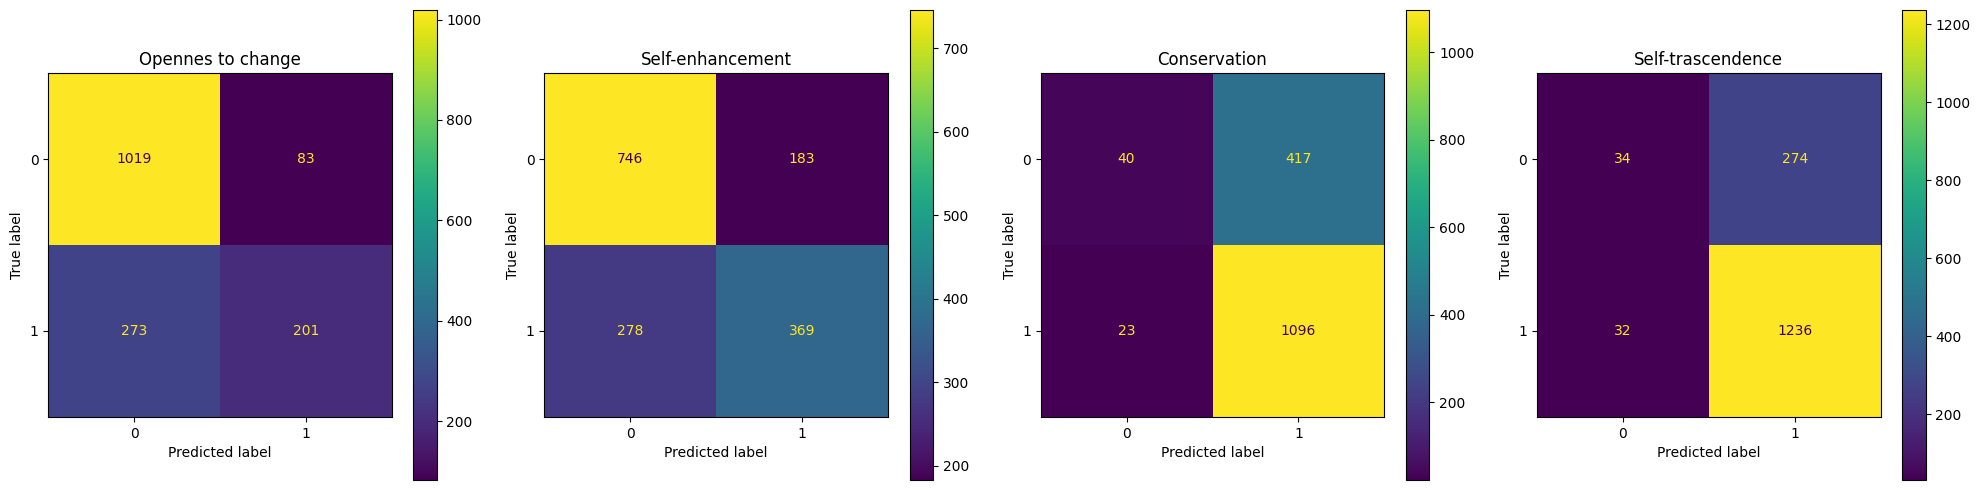

In [100]:
# Confusion matrix per label of CP model
mcm = multilabel_confusion_matrix(CPS_encoded_ds['test']['labels'],preds_CP)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Confusion matrices CP model", fontsize=15)
axs = axes.flatten()
for i,cm in enumerate(mcm):
  ConfusionMatrixDisplay(cm).plot(ax = axs[i])
  axs[i].set_title(LABELS[i])
plt.tight_layout()
plt.show()

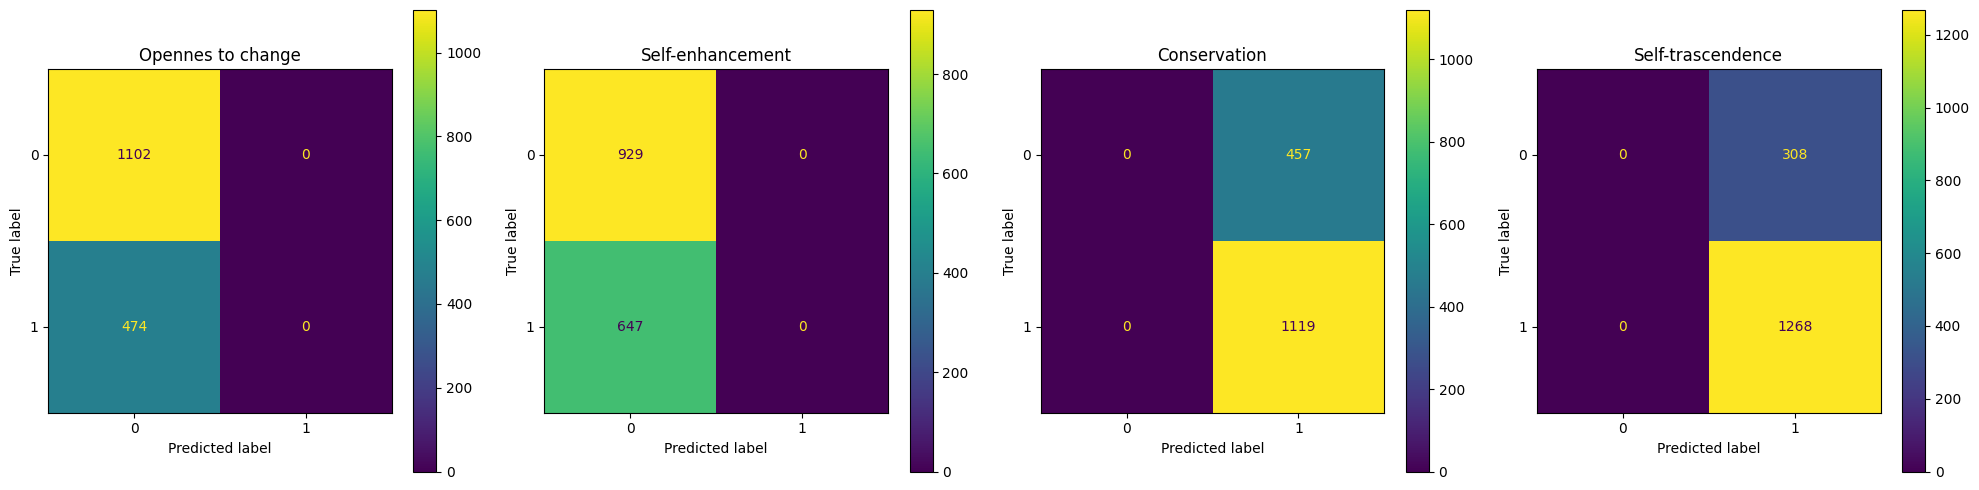

In [103]:
# Confusion matrix per label of RUC model
mcm = multilabel_confusion_matrix(CPS_encoded_ds['test']['labels'],mc_preds)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Confusion matrices RUC model", fontsize=15)
axs = axes.flatten()
for i,cm in enumerate(mcm):
  ConfusionMatrixDisplay(cm).plot(ax = axs[i])
  axs[i].set_title(LABELS[i])
plt.tight_layout()
plt.show()

As expected, the Bert models outperform the baseline models which do not consider the input data.

Among the three BERT models, BERT/C performs the worst. Regarding BERT/CP and BERT/CPS we can get no conclusion of which one of the two is better since including the stance changes almost nothing the results due probably to the fact that including stance information might introduce redundant or irrelevant details to the model.

Conservation and self transcendence seem labels easy to be classified, most likely due to its frequency with one of the values. We can justify taking a look at the majority classifier that always picking the majority label will give us a really high score.

Openness to change and self enhancement are, on the other hand, labels difficult to be classified. This could be due to the incapability of the classifier to get a clear idea of the pattern with the amount of data.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End